## Comparing a new interpolation method for HYDMOD with MOD2SMP
`mod2smp` allows for interpolation at the edges of active cells in a MODFLOW grid. However, the previous version of `HYDMOD` (Version 7) returned an error if a cell that is inactive or outside the grid was going to be needed for interpolation. Instead of this, dummy values (based on adjacent active cells) are adopted instead. 

Results are compared on a synthetic model with `mod2smp`. 

Important limitations - this only applies to head and drawdown (not subsidence).

In [1]:
from __future__ import print_function
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import flopy as fp
import flopy.utils as fu
import platform
if 'window' not in platform.platform().lower():
    newln = '\r\n'
else:
    newln = '\n'

## Take an existing PCG verion of the model and, with `flopy` convert to PCG

In [2]:
# convert model to PCG from NWT
mod = fp.modflow.Modflow.load('freyberg.nam')
mod.name ='freyberg_pcg'
upw = mod.get_package('UPW')
pcg = fp.modflow.ModflowPcg(mod)
lpf = fp.modflow.ModflowLpf(mod,hk=upw.hk, vka=upw.vka, ss=upw.ss, sy = upw.sy)
mod.remove_package('UPW')
mod.remove_package('NWT')
mod.version ='mf2005'
bas = mod.get_package('BAS6')
bas.hnoflo = -232323


  ...load method not completed. default nwt file created.


### need a little function to read in the model orientation

In [3]:
def line_splitter(line):
    if ',' in line:
        return line.strip().split(',')
    else:
        return line.strip().split()

def grid_spec_reader(infile):
    indat = open(infile, 'r').readlines()
    # read the top two lines of headers
    nrows, ncols = [int(i) for i in line_splitter(indat.pop(0))]
    xul, yul, theta =[float(i) for i in line_splitter(indat.pop(0))]
    # read the delr and delcol values --- first just into a list, then parse
    spacings = list()
    for line in indat:
        line = [float(i) for i in line_splitter(line)]
        if '*' not in line:
            spacings.extend(line)
        else:
            raise('need to handle multiplier types')
    delc = np.array(spacings[:nrows])
    delr = np.array(spacings[nrows:])
    return nrows,ncols,xul,yul,theta,delr,delc

In [4]:
# first read in the model.spc file to obtain the model upper left coordinate
nrows,ncols,xul,yul,theta,delr,delc = grid_spec_reader('freyberg.spc')

# also find xll and yll
xll = xul
yll = yul - np.sum(delc)
print (xul, yul)
print (xll,yll)
print (np.sum(delr))
print (np.sum(delc))
print (250*40)

619653.0 3353277.0
619653.0 3343277.0
5000.0
10000.0
10000


## Read in the bore coordinates
This ensures that the locations are the same as the values used my mod2smp.

Originally, the locations were specified at the centers of all active cells in the model. Added random noise to them to make them offset and force real interpolation to happen.

In [5]:
# now read in the locations for which output is desired
obswells = pd.read_csv('bore.crds', header=None, delim_whitespace=True,names=
                       ['obsname','x','y','lay'])
obswells['x_mod'] = obswells.x-xll
obswells['y_mod'] = obswells.y-yll

obswells.describe()

,x,y,lay,x_mod,y_mod
count,705.000000,705.000000,705,705.000000,705.000000
mean,622277.245390,3348433.075177,1,2624.245390,5156.075177
std,1422.790456,2851.799570,0,1422.790456,2851.799570
min,619654.000000,3343280.000000,1,1.000000,3.000000
25%,621110.000000,3345994.000000,1,1457.000000,2717.000000
50%,622376.000000,3348293.000000,1,2723.000000,5016.000000
75%,623482.000000,3351031.000000,1,3829.000000,7754.000000
max,624639.000000,3353273.000000,1,4986.000000,9996.000000


## Put HYDMOD into the `flopy` model object and write new model

In [6]:
# set up HYDMOD in flopy
NHYD = len(obswells)
IHYDUN = 42
HYDNOH = -9999999
PCKG = 'BAS'
ARR = 'HD'
hydinfo = []
for crec in obswells.iterrows():
    r,c = [int(i)+1 for i in re.findall('\d+', crec[1].obsname)]
    INTYP = 'H'
    hydinfo.append([PCKG, ARR, INTYP, crec[1].lay, crec[1].x-xll, crec[1].y-yll, crec[1].obsname])
hyd = fp.modflow.ModflowHyd(mod, nhyd=NHYD, ihydun=IHYDUN, hydnoh=HYDNOH, obsdata=hydinfo)
mod.write_input()

# Now compare HYDMOD output with `mod2smp`

### first read in the mod2smp output and create a time index

In [7]:
# READ IN THE MOD2SMP OUTPUT
mod2obs = pd.read_csv('freyberg_heads.smp', delim_whitespace=True, 
                      names=['location','date','time','head'])
mod2obs.head()

,location,date,time,head
0,OR00C00,02/01/2015,00:00:00,23.12988
1,OR00C00,01/01/2020,00:00:00,20.58575
2,OR00C00,02/01/2020,00:00:00,20.57530
3,OR00C01,02/01/2015,00:00:00,23.11162
4,OR00C01,01/01/2020,00:00:00,20.57784


In [8]:
# find the unique times
dates = mod2obs.date.unique()
dates

array(['02/01/2015', '01/01/2020', '02/01/2020'], dtype=object)

In [9]:
# set up a sequential number to make it easier to compare with HYDMOD output
for i,cdate in enumerate(dates):
    mod2obs.loc[mod2obs.date==cdate,'timeind'] = str(i+1)
mod2obs['date_loc'] = mod2obs[['location','timeind']].apply(lambda x: '_'.join(x), axis=1)

In [10]:
results_end = mod2obs.loc[mod2obs['timeind']=='3']

In [11]:
# take a look at the dataframe making sure it looks OK
results_end.head()

,location,date,time,head,timeind,date_loc
2,OR00C00,02/01/2020,00:00:00,20.57530,3,OR00C00_3
5,OR00C01,02/01/2020,00:00:00,20.56743,3,OR00C01_3
8,OR00C02,02/01/2020,00:00:00,20.50915,3,OR00C02_3
11,OR00C03,02/01/2020,00:00:00,20.48402,3,OR00C03_3
14,OR00C04,02/01/2020,00:00:00,20.35657,3,OR00C04_3


### Now read in the HYDMOD output

In [12]:
obsresults = fu.HydmodObs('freyberg_pcg.hyd.bin')

Get rid of the extra label prepended onto our labels by HYDMOD

In [13]:
labels = [i.upper().replace('HDC001','') for i in obsresults.get_hyd_labels()]
labels = [i.replace('HDI001','') for i in labels]
labels = [i.replace('HDH001','') for i in labels]

values = obsresults.get_values(-1)[1]

In [14]:
# make a dataframe
hydmod_df = pd.DataFrame(data={'label':labels,'values':values})
hydmod_df.head()

,label,values
0,OR00C00,20.575298
1,OR00C01,20.567429
2,OR00C02,20.509150
3,OR00C03,20.484016
4,OR00C04,20.356564


### merge the results into the mod2smp dataframe

In [15]:
results_end = results_end.merge(hydmod_df,left_on='location', right_on='label')

In [16]:
results_end.rename(columns={'values':'hydmod','head':'mod2smp'}, inplace=True)

In [17]:
row,col = [],[]
for cn in results_end.location.tolist():
    r,c = [int(i) for i in re.findall('\d+', cn)]
    row.append(r), col.append(c)

In [18]:
results_end['row'] = row
results_end['col'] = col
nrow = np.max(row)+1
ncol = np.max(col)+1

Make matrices of the interpolated heads as read in. Note that values where a noflow value was interpolated in modssmp  are maskedout with NaN for now. HYDMOD in the new form won't allow that result to happen

In [19]:
hydmodheads = np.ones((nrow,ncol))*np.nan
mod2smpheads = np.ones((nrow,ncol))*np.nan
hydmodheads[results_end.row.as_matrix(),results_end.col.as_matrix()] = results_end.hydmod.as_matrix()
mod2smpheads[results_end.row.as_matrix(),results_end.col.as_matrix()] = results_end.mod2smp.as_matrix()

hydmodheads[hydmodheads<0] = np.nan
mod2smpheads[mod2smpheads<0]=np.nan


### Plot up comparisons

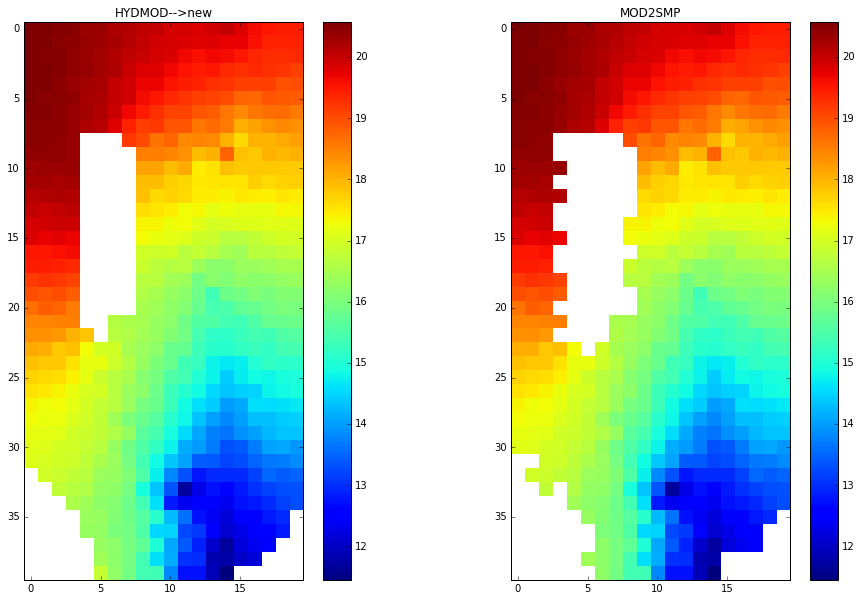

In [20]:
vmin, vmax = np.nanmin(mod2smpheads), np.nanmax(mod2smpheads)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(hydmodheads, interpolation='nearest', vmin = vmin, vmax=vmax)
#plt.imshow(hydmodheads, interpolation='nearest')
plt.colorbar()
plt.title('HYDMOD-->new')
plt.subplot(122)
plt.imshow(mod2smpheads, interpolation='nearest', vmin = vmin, vmax=vmax)
plt.title('MOD2SMP')
plt.colorbar()

### and plot the differences

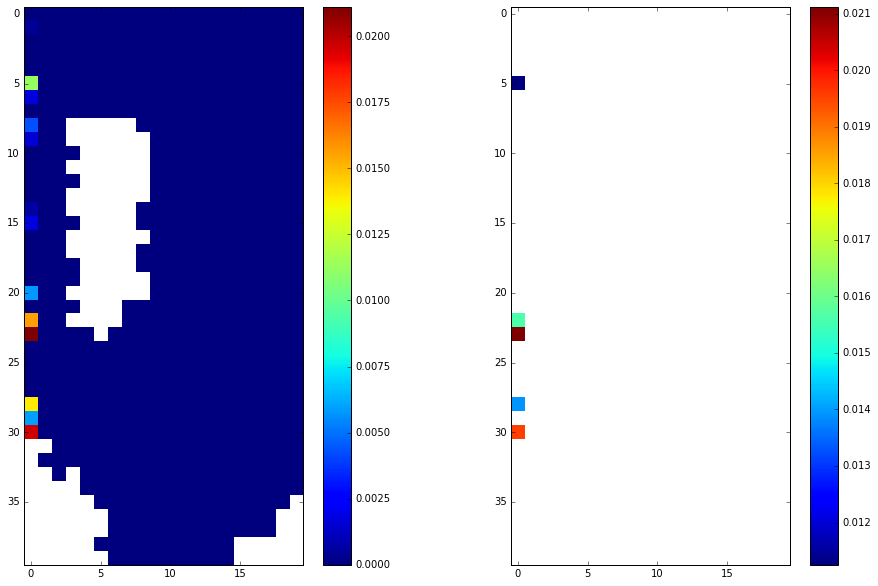

In [21]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(hydmodheads-mod2smpheads, interpolation='nearest')
plt.colorbar()
plt.subplot(122)
diffs = hydmodheads-mod2smpheads
diffs[np.abs(diffs)<1e-2] = np.nan
plt.imshow(diffs, interpolation='nearest')
plt.colorbar()


### plot differences as a percentage of mod2smp values

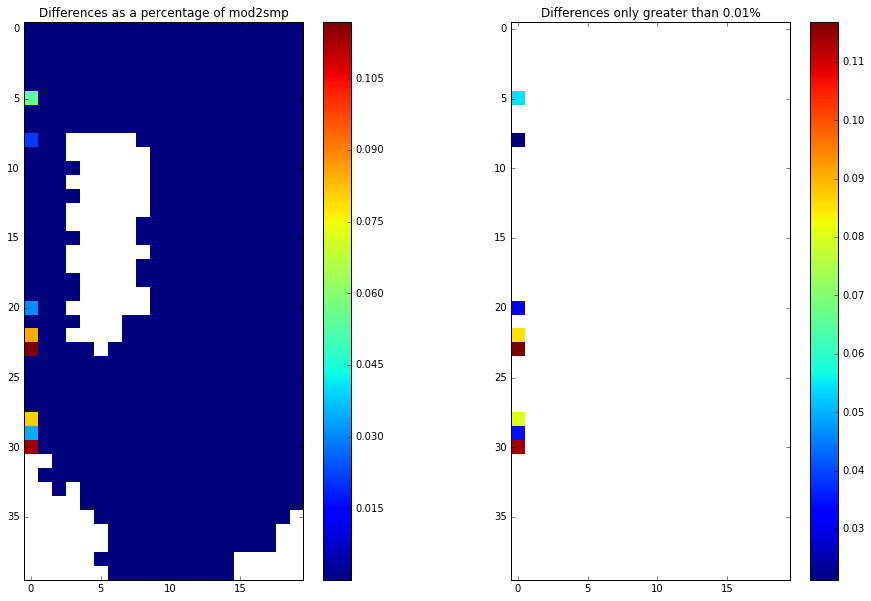

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(121)
diffs = [np.abs(hydmodheads-mod2smpheads)]/mod2smpheads * 100.

plt.imshow(diffs[0,:,:], interpolation='nearest')
plt.colorbar()
plt.title('Differences as a percentage of mod2smp')
plt.subplot(122)
diffs[diffs<0.01] = np.nan
plt.imshow(diffs[0,:,:], interpolation='nearest')
plt.colorbar()
plt.title('Differences only greater than 0.01%')


In [23]:
diffs.shape

(1, 40, 20)

In [24]:
results_end[results_end['col']==0]

,location,date,time,mod2smp,timeind,date_loc,label,hydmod,row,col
0,OR00C00,02/01/2020,00:00:00,20.57530,3,OR00C00_3,OR00C00,20.575298,0,0
20,OR01C00,02/01/2020,00:00:00,20.57645,3,OR01C00_3,OR01C00,20.576889,1,0
40,OR02C00,02/01/2020,00:00:00,20.56732,3,OR02C00_3,OR02C00,20.567322,2,0
60,OR03C00,02/01/2020,00:00:00,20.56260,3,OR03C00_3,OR03C00,20.562603,3,0
80,OR04C00,02/01/2020,00:00:00,20.55502,3,OR04C00_3,OR04C00,20.555019,4,0
100,OR05C00,02/01/2020,00:00:00,20.54301,3,OR05C00_3,OR05C00,20.554264,5,0
120,OR06C00,02/01/2020,00:00:00,20.51411,3,OR06C00_3,OR06C00,20.515774,6,0
140,OR07C00,02/01/2020,00:00:00,20.48340,3,OR07C00_3,OR07C00,20.483398,7,0
160,OR08C00,02/01/2020,00:00:00,20.47131,3,OR08C00_3,OR08C00,20.475674,8,0
177,OR09C00,02/01/2020,00:00:00,20.41819,3,OR09C00_3,OR09C00,20.419765,9,0


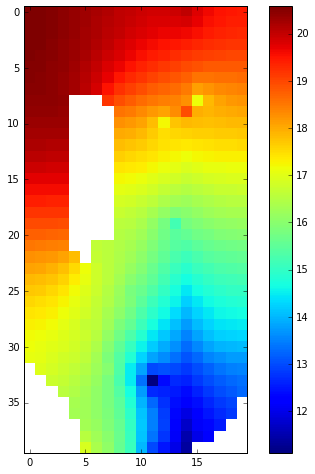

In [25]:
# read in the heads
heads = fu.binaryfile.HeadFile('freyberg_pcg.hds')
inheads = heads.get_alldata()
inheads[inheads<-10000] = np.nan
plt.figure(figsize=(8,8))
plt.imshow(inheads[2,0,:,:], interpolation='nearest')
plt.colorbar()